In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
np.random.seed(10)
import tensorflow as tf
tf.set_random_seed(10)
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 16, # fontsize for x and y labels (was 10)
    'axes.titlesize': 16,
    'font.size': 16, # was 10
    'legend.fontsize': 16, # was 10
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'text.usetex': True,
    'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
}
plt.rcParams.update(params)

In [2]:
# Generating training data that goes from initial condition location to PCA coefficient trajectory
num_modes=40
locs = np.load('../../SWE_Data/Data/Locations.npy')
pca_coeffs = np.load('../../SWE_Data/PCA_Coefficients_q1.npy')[0:num_modes,:]

coeff_scaler = MinMaxScaler()
pca_coeffs_scaled = np.transpose(coeff_scaler.fit_transform(np.transpose(pca_coeffs)))

In [3]:
num_sims = np.shape(locs)[0]
num_ivs = np.shape(locs)[1]
num_coeffs = np.shape(pca_coeffs)[0]
burn_in = 20

In [4]:
# Reshape
raw_training_data = np.zeros(shape=(num_sims,num_coeffs+num_ivs,500),dtype='double')

for sim in range(num_sims):
    raw_training_data[sim,:-num_ivs,:] = pca_coeffs_scaled[:,500*sim:500*(sim+1)]
    raw_training_data[sim,-num_ivs:,:] = locs[sim,:,None]

In [5]:
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras import optimizers
from tcn import TCN ### Need to install tcn using `pip install keras-tcn`

In [6]:
# Best hyperparameters found using deephyper - first line of results.csv
batch_size = None
inputs = Input(batch_shape=(batch_size, 42, burn_in))
tcn_output = TCN(88,return_sequences=True,activation='tanh')(inputs)  # The TCN layers are here.
tcn_output = TCN(88,return_sequences=True,activation='tanh')(tcn_output)  # The TCN layers are here.
output = Dense(500-burn_in,activation='linear')(tcn_output)
m = Model(inputs=[inputs], outputs=[output])

my_adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
m.compile(optimizer=my_adam, loss='mse')

filepath = "NA_TCN.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
earlystopping = EarlyStopping(monitor='loss', min_delta=0, patience=100, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
callbacks_list = [checkpoint]

m.summary()

W0208 21:02:15.068412 139994242217792 deprecation.py:506] From /home/rmlans/anaconda3/envs/deephyper_env/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 42, 20)]          0         
_________________________________________________________________
tcn (TCN)                    (None, 42, 88)            227920    
_________________________________________________________________
tcn_1 (TCN)                  (None, 42, 88)            233904    
_________________________________________________________________
dense (Dense)                (None, 42, 480)           42720     
Total params: 504,544
Trainable params: 504,544
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Load in data into windowed input and windowed output
input_window_length = burn_in
output_window_length = 500-burn_in
num_timesteps_per_simulation = 500
state_len = 42
num_sims = 20

training_data_ip = np.zeros(shape=(num_sims,state_len,burn_in))
training_data_op = np.zeros(shape=(num_sims,state_len,500-burn_in))

for sim_num in range(num_sims):
    training_data_ip[sim_num,:,:] = raw_training_data[sim_num,:,0:burn_in]
    training_data_op[sim_num,:,:] = raw_training_data[sim_num,:,burn_in:]

In [8]:
from time import time
train_mode = False ##Careful
if train_mode:
    start_time = time()
    history = m.fit(training_data_ip, training_data_op, epochs=5000, callbacks=callbacks_list)
    np.save('NA_TCN.npy',history.history['loss'])
    end_time = time()

## Testing

In [9]:
# Testing
m.load_weights(filepath)
filename = '../../SWE_Data/Data/snapshot_matrix_pod_test.npy'
test_data = np.load(filename)[0:64*64,:]
pca_vectors = np.load('../../SWE_Data/PCA_Vectors_q1.npy')[:64*64,:num_modes]

true_pca_evol = coeff_scaler.transform(np.matmul(np.transpose(test_data),pca_vectors))
test_data = np.zeros(shape=(1,num_coeffs+num_ivs,500))
test_data[0,0:num_coeffs,:] = np.transpose(true_pca_evol[:,:])

test_data[0,-2,:] = -1.0/2.7
test_data[0,-1,:] = -1.0/4.0

pred_pca = m.predict(test_data[:,:,:burn_in])
pred_pca = np.concatenate((test_data[:,:,:burn_in],pred_pca),axis=-1)

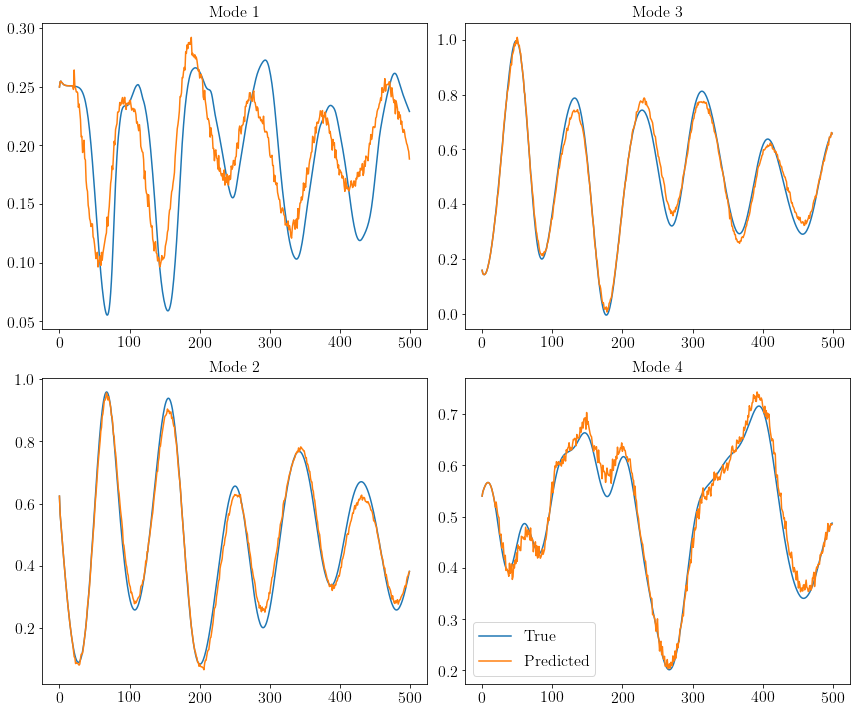

In [10]:
fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(12,10))
ax[0,0].plot(test_data[0,0,:],label='True')
ax[0,0].plot(pred_pca[0,0,:],label='Predicted')
ax[0,0].set_title('Mode 1')


ax[1,0].plot(test_data[0,1,:],label='True')
ax[1,0].plot(pred_pca[0,1,:],label='Predicted')
ax[1,0].set_title('Mode 2')

ax[0,1].plot(test_data[0,2,:],label='True')
ax[0,1].plot(pred_pca[0,2,:],label='Predicted')
ax[0,1].set_title('Mode 3')

ax[1,1].plot(test_data[0,3,:],label='True')
ax[1,1].plot(pred_pca[0,3,:],label='Predicted')
ax[1,1].set_title('Mode 4')

plt.tight_layout()
plt.legend()
plt.show()

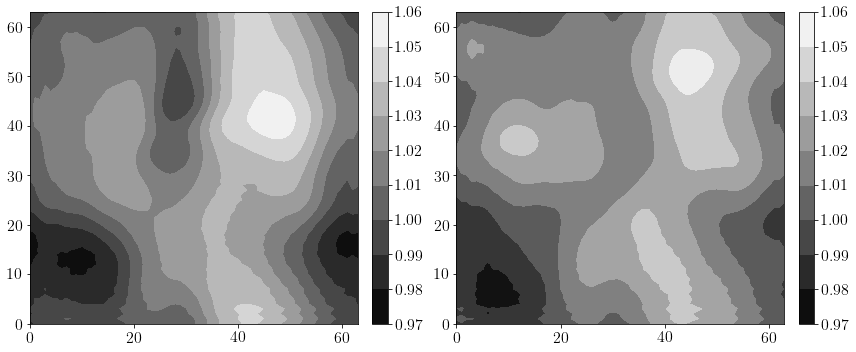

In [11]:
# Plotting some contours
# True field
true_rb = np.transpose(coeff_scaler.inverse_transform(true_pca_evol))
true_recon = np.matmul(pca_vectors,true_rb)[:,-2].reshape(64,64)

pred_rb = np.transpose(pred_pca[0,:num_modes,:])
pred_rb = np.transpose(coeff_scaler.inverse_transform(pred_rb))
pred_recon = np.matmul(pca_vectors,pred_rb)[:,-2].reshape(64,64)


fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(12,5))
cx = ax[0].contourf(true_recon)
ax[1].contourf(pred_recon)

fig.colorbar(cx,ax=ax[0],fraction=0.046, pad=0.04)
fig.colorbar(cx,ax=ax[1],fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

In [12]:
if train_mode:
    np.save('Figures/NA_TCN_Preds.npy',pred_pca)
    np.save('Figures/NA_TCN_Fields.npy',pred_recon)